In [24]:
import pandas as pd
import numpy as np
import os

In [25]:
print("File location using os.getcwd():", os.getcwd())

# default path for local execution on PC
PATH = 'nsrdb-tours/' # input folder
WORK_DIR = PATH  # output folder

if "google.colab" in str(get_ipython()):
    print("Running on CoLab")
    PATH = "/content/drive/My Drive/Colab Notebooks/time_series/"  # input
    WORK_DIR = PATH  # output

    # mount like on Linux
    from google.colab import drive

    drive.mount("/content/drive")

elif "kaggle" in str(os.getcwd()):
    PATH = "/kaggle/input/nsrdb-tours/"  # input
    WORK_DIR = "/kaggle/working/darts_logs/"  # output
    from learntools.time_series.utils import *
    from learntools import *
    
else: # on local PC
    from ds_utils import *
    from ds_time_series import *

File location using os.getcwd(): /kaggle/working


In [26]:
# Define the latitude and longitude values
latitude = '47.41'
longitude = '0.70'

# Define the base name of the CSV files
base_name = PATH + f'359516_{latitude}_{longitude}_'

# List of years
years = [2017, 2018, 2019]

# Initialize an empty list to hold DataFrames
dfs = []

# Loop over the years, read the CSV files and process them
for year in years:
    # Create the full file name
    file_name = base_name + str(year) + '.csv'
    print(file_name)
    # Read the CSV file
    df = pd.read_csv(file_name, skiprows=2)
    
    # Append the processed DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list into a whole dataset
df = pd.concat(dfs)

# Generate a datetime index column
df['datetime'] = pd.to_datetime(df['Year'].astype(str) +'-'
                                + df['Month'].astype(str) + '-'
                                + df['Day'].astype(str) + ' '
                                + df['Hour'].astype(str) + ':'
                                + df['Minute'].astype(str) + ':00')

# Drop useless columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

# Set datetime as index
df = df.set_index('datetime')

# accelerate processing by reducing information
# df = df.astype(np.float32)

df.info()  # check dataframe info

/kaggle/input/nsrdb-tours/359516_47.41_0.70_2017.csv
/kaggle/input/nsrdb-tours/359516_47.41_0.70_2018.csv
/kaggle/input/nsrdb-tours/359516_47.41_0.70_2019.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105120 entries, 2017-01-01 00:00:00 to 2019-12-31 23:45:00
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         105120 non-null  float64
 1   Clearsky DHI        105120 non-null  int64  
 2   Clearsky DNI        105120 non-null  int64  
 3   Clearsky GHI        105120 non-null  int64  
 4   Cloud Type          105120 non-null  int64  
 5   Dew Point           105120 non-null  float64
 6   DHI                 105120 non-null  int64  
 7   DNI                 105120 non-null  int64  
 8   Fill Flag           105120 non-null  int64  
 9   GHI                 105120 non-null  int64  
 10  Ozone               105120 non-null  float64
 11  Relative Humidity   105120 non-null  floa

In [4]:
#missing_data_percentage(df)

In [5]:
# Rename the values in the "Cloud Type" column
cloud_type_mapping = {
   0:  'Clear',
   1:  'Probably Clear',
   2:  'Fog',
   3:  'Water',
   4:  'Super-Cooled Water',
   5:  'Mixed',
   6:  'Opaque Ice',
   7:  'Cirrus',
   8:  'Overlapping',
   9:  'Overshooting',
   10: 'Unknown',
   11: 'Dust',
   12: 'Smoke',
   -15:'N/A',
}
df['Cloud Type Name'] = df['Cloud Type'].map(cloud_type_mapping)

In [6]:
fill_flag_mapping = {
    0: 'N/A',
    1: 'Missing Image',
    2: 'Low Irradiance',
    3: 'Exceeds Clearsky',
    4: 'Missing Cloud Properties',
    5: 'Rayleigh Violation'
}
df['Fill Flag Name'] = df['Fill Flag'].map(fill_flag_mapping)

In [7]:
#rotation to convert from zenith angle to solar altitude
df['Solar Altitude Angle'] = 90 - df['Solar Zenith Angle']

#the sun is down when the angle is under 0 (the horizon)
df['Solar Altitude Angle'][df['Solar Altitude Angle'] <= 0] = 0

daylight = df['Solar Zenith Angle'] <= 90
df["daylight"] = (daylight).astype(int)

/tmp/ipykernel_33/723805363.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Solar Altitude Angle'][df['Solar Altitude Angle'] <= 0] = 0
/tmp/ipykernel_33/723805363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

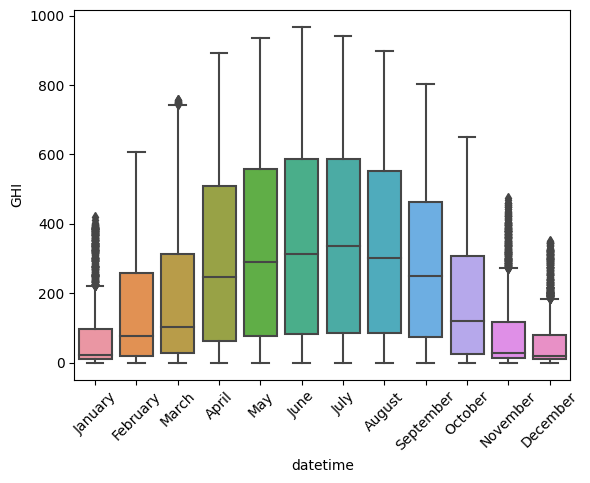

In [8]:
sns.boxplot(x=df[daylight].index.month_name(), y='GHI', data=df[daylight])
plt.xticks(rotation=45)
plt.show()

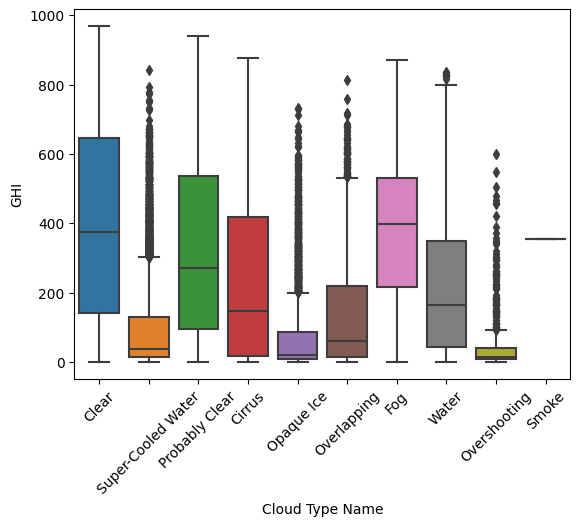

In [9]:
sns.boxplot(x='Cloud Type Name', y='GHI', data=df[daylight])
plt.xticks(rotation=45)
plt.show()

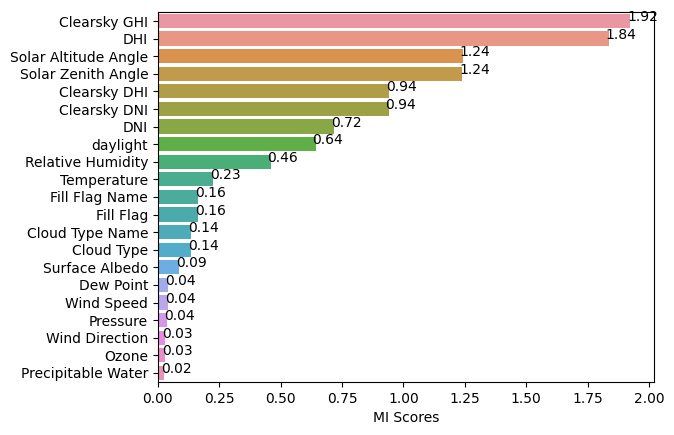

In [10]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Compute mutual information scores for features in X relative to target y.
    Example:
    make_mi_scores(df.drop("y", axis=1), df["y"])
    """
    from sklearn.feature_selection import mutual_info_regression
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

def plot_scores(scores: pd.Series, score_type: str):
    scores = scores.sort_values(ascending=False)  # Seaborn prefers this orientation
    sns.barplot(x=scores, y=scores.index)

    if score_type == "mi":
        plt.xlabel("Mutual Information Scores")
    elif score_type == "corr":
        plt.xlabel("Correlation Scores")

    # Add a text label to each bar with the corresponding score
    for i, score in enumerate(scores):
        plt.text(score + 0.05, i, f"{score:.2f}", ha="center")

mi_scores = make_mi_scores(df.drop("GHI", axis=1), df["GHI"])
plot_scores(mi_scores, "Mutual Information Scores")

#https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html

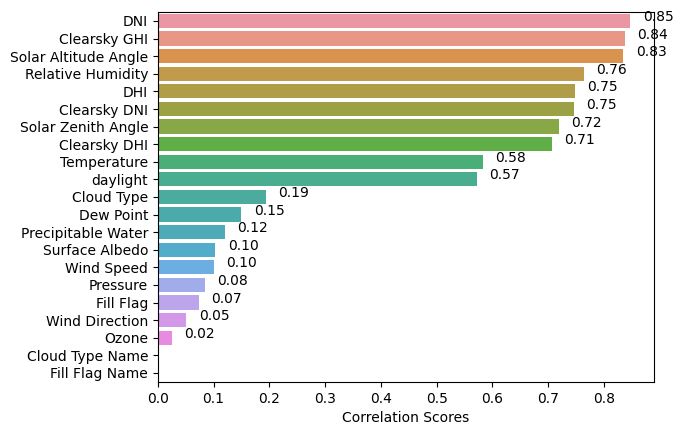

In [11]:
def make_corr_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Compute correlation scores for features in X relative to target y."""
    # Check the data types of the columns in X and y
    X_numeric = X.select_dtypes(include=['number'])
    y_numeric = y.to_frame().select_dtypes(include=['number'])

    # If y is not numeric, raise an error
    if y_numeric.empty:
        raise ValueError("Target variable y must be numeric")

    # Compute the correlation scores for the numeric columns in X
    corr_scores = X_numeric.corrwith(y_numeric.iloc[:,0])
    corr_scores = pd.Series(corr_scores, name="Correlation Scores", index=X.columns)
    corr_scores = corr_scores.abs().sort_values(ascending=False)
    return corr_scores

corr_scores = make_corr_scores(df.drop("GHI", axis=1), df["GHI"])
plot_scores(corr_scores, "corr")

# Solar zenith and altitude angle

We use deterministic astronomical data to obtain information on the angular altitude of the sun during the day and during the year.

* Zenith angle, between the sun’s rays and the vertical direction
* Altitude angle from 0 (no sun) to 90

https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html

<img src="https://www.mdpi.com/sensors/sensors-21-06259/article_deploy/html/images/sensors-21-06259-g002.png" alt= “” width="750" height="value">

CC BY 4.0 Zhang et al.
DOI:10.3390/s21186259

https://nsrdb.nrel.gov/data-sets/us-data

<Axes: xlabel='datetime', ylabel='Clearsky GHI'>

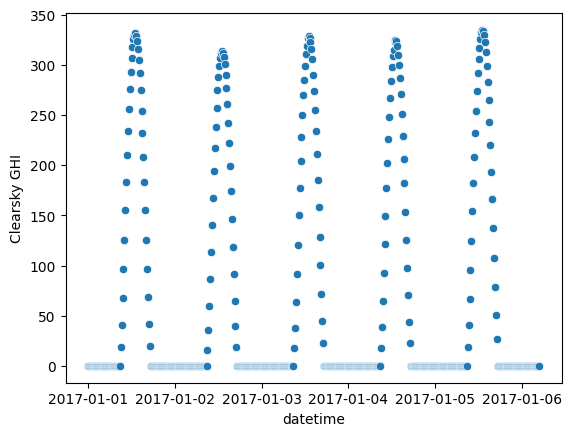

In [23]:
sns.scatterplot(df['Clearsky GHI'][0:500])

<Axes: xlabel='datetime', ylabel='GHI'>

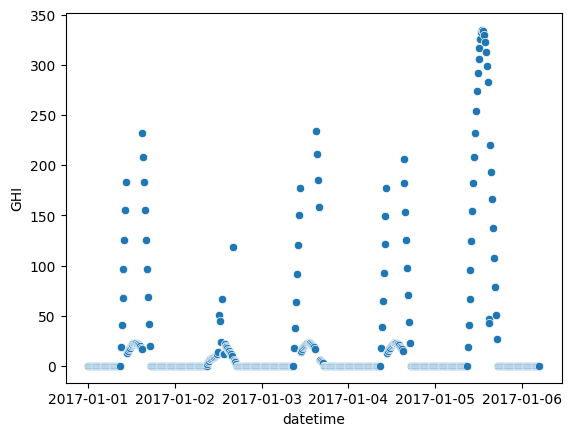

In [22]:
sns.scatterplot(df['GHI'][0:500])

In [12]:
# Create sine feature
df["sin_solar_altitude"] = np.sin(df["Solar Altitude Angle"] * np.pi / 180)

# Create cosine feature
df["cos_solar_altitude"] = np.cos(df["Solar Altitude Angle"] * np.pi / 180)

In [13]:
features = [
    "Solar Altitude Angle",
    "daylight",
    "Relative Humidity",
    "Temperature",
    #"sin_solar_altitude",
    #"cos_solar_altitude",
    #"Dew Point",
    #"Pressure",
    #"Precipitable Water",
    #"Wind Direction",
    #"Wind Speed",
]

In [14]:
X = df.copy()  # X - independent features(excluding target variable)
y = X.pop("GHI")  # y - dependent variables, called (target), to predict

X = X[features]

In [15]:
X_clustered = kmeans_clustering(X.drop(["daylight"], axis=1), n_clusters=3)
#https://scikit-learn.org/stable/modules/clustering
plot_clusters(X_clustered, y)

NameError: name 'kmeans_clustering' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0
)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [
    cname
    for cname in X_train_full.columns
    if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == "object"
]

# Select numerical columns
numerical_cols = [
    cname
    for cname in X_train_full.columns
    if X_train_full[cname].dtype in ["int64", "float64", "float32"]
]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Preprocessing of training data, fit model
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
y_preds = clf.predict(X_valid)

print("MAE:", mean_absolute_error(y_valid, y_preds))

In [ ]:
df_y_preds = pd.DataFrame(y_preds, index=y_valid.index, columns=["GHI_predicted"])

In [ ]:
_ = plot_lags(df["GHI"], lags=12, nrows=2)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["GHI"], lags=2*24*2);

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["GHI"], lags=2*24*2);

In [ ]:
## YOUR CODE HERE: Make features from `y_deseason`
#X_lags = make_lags(y, lags=1)
#
## YOUR CODE HERE: Make features from `onpromotion`
## You may want to use `pd.concat`
#X_promo = pd.concat([
#    make_lags(onpromotion, lags=1),
#    onpromotion,
#    make_leads(onpromotion, leads=1),
#], axis=1)
#
#X = pd.concat([X_lags, X_promo], axis=1).dropna()
#y, X = y.align(X, join='inner')

In [ ]:
#seasonal_plot(X, y=y.name, period='week', freq='day');

In [ ]:
average_y = (
    y
    .groupby('datetime').mean()
    .squeeze()
    .loc['2017']
)

In [ ]:
plot_periodogram(average_y, 365);